In [1]:
import os
import pickle
import matplotlib.pyplot as plt
from statistics import mean
import math
import cloudpickle
import gzip
import matplotlib as mpl

from math import log

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 16, 9
rcParams.update({'figure.max_open_warning': 0,'font.size': 14,'axes.titlesize': 14,'axes.labelsize': 14,
                 'axes.grid':True,'xtick.direction': 'in','ytick.direction': 'in','ytick.right': True,
                 'xtick.top':True,'ytick.major.size': 10,'xtick.major.size': 10,'legend.fancybox': True,
                 'legend.markerscale': 0.8,'legend.handlelength': 5.0
                 #'axes.prop_cycle': cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']),                 
                 #'xtick.labelsize': 12,
                 #'ytick.labelsize': 12
                })

#from cycler import cycler
mpl.rcParams['grid.linestyle'] = '-.'
#rcParams.keys() 
#plt.style.use('dark_background')
#print(plt.style.available)


In [4]:
dirname = '/home/furkan/work/flicanalyzer/pypuca/dune/pods/'
hists={}
allArrays = np.array([])
for filename in sorted(os.listdir(dirname)):
    if '.pkl.gz' in filename:
            with gzip.open(dirname+filename,'rb') as fin:
                mydata = pickle.load(fin)
                
                for k in mydata.keys():
                    if 'channel_132'==k:

                        if k in hists: 
                            #allArrays  = np.concatenate((hists[k], mydata[k]))
                             hists.update({k: np.concatenate((hists[k], mydata[k]))  })
                            #allArrays  = np.concatenate((hists[k], mydata[k]))
                        else: hists[k] = mydata[k]

                    #mydata = pickle.load(fin)
                    #np.concatenate((array2D_1, array2D_2))


In [7]:
hists['channel_132'].shape

(34418, 2000)

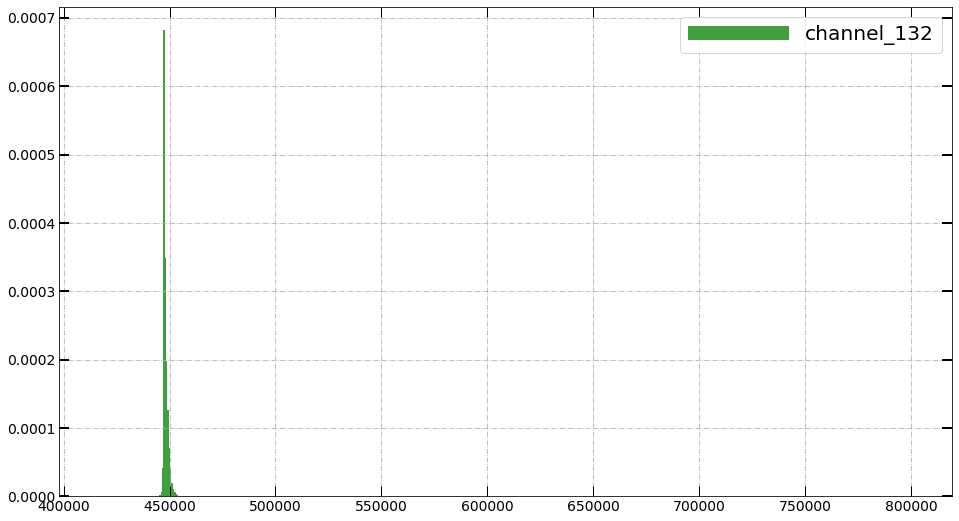

In [9]:
import scipy.integrate as integrate

data=hists['channel_132']
integArr = np.array([])
for row in data:
    baseline = evtselect[0:row.size, 800:1050].mean(axis=1)
    indata= row[1060:1350,]
    result_simps = integrate.simps(indata)
    #print(result_simps)
    integArr = np.append(integArr, result_simps)
    #print(integArr.shape)
    #plt.plot(integArr)
from scipy.stats import norm

plt.hist(integArr, bins=600, density=True, facecolor='g', alpha=0.75, label='channel_132')
#sns.distplot(integArr, kde=True)
#sns.distplot(integArr,fit=stats.maxwell)

#plt.yscale('log')
plt.grid(True)
plt.xlim(-10000, 5000000)

plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

plt.show()
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAA78AAAIJCAYAAABtBIpGAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAADh0RVh0U29mdHdhcmUAbWF0cGxvdGxpYiB2ZXJzaW9uMy4xLjIsIGh0dHA6Ly9tYXRwbG90bGliLm9yZy8li6FKAAAgAElEQVR4nOzde3SV9Z33/c+PJOwEE5RgCUhAQocghGkw7FsGRSBO7cGxTztj786jqy324FSZ2sdp6z2rU9f0dNeeHMfeXfXw9OCgfe4ZV8dW57ZWHacBmjaTTnZKLOEQO4SWIIQhQUmUBJL8nj+yidnJTnIhh+v67uv9Woul7uuXa/+Sdzer31z74Lz3AgAAAAAgl00LewMAAAAAAJxrDL8AAAAAgJzH8AsAAAAAyHkMvwAAAACAnMfwCwAAAADIeQy/AAAAAICclx/2Bs6niy++2C9atCjjtpdeekmXXHJJOBtCYHSKPhrZQCcb6GQDnWygkw10ssFCp1QqdcR7/6Zsx1ycPuc3mUz6pqamjNucc4rTz8AqOkUfjWygkw10soFONtDJBjrZYKGTcy7lvU9mO8bTngEAAAAAOY/hFwAAAACQ8xh+AQAAAAA5j+EXAAAAAJDzAg+/zrlNzrl251yfcy7lnLt6ivXr0+v6nHN7nXO3nu45nXMJ59y3nHNHnHOvOuf+xTlXPur4zc45P8Gf/xb0ewMAAAAA5LZAw69z7s8lfVPS3ZIul/RLST91zi2cYH2FpKfT6y6X9BVJ33LO3XCa57xP0g2SbpR0taSZkp5yzuWljz8mad6YPz+Q1C4p822dAQAAAACxFeijjpxzjZJe8N7fMuq2FyX9s/f+M1nWf03Sn3nvl4y67buSqrz3a4Kc0zl3oaT/kvQh7/3/lz6+QNLvJL3Te/9slvudIeklSV/33t899jgfdWQXnaKPRjbQyQY62UAnG+hkA51ssNDpjD7qyDk3XdIqSc+NOfScpCsn+LI1WdY/KynpnCsIeM5VkgpGr/He75e0a5L7fZ+kCyQ9PNH3AwAAAACIn/wAay6WlCepc8ztnZLeOsHXzJX0fJb1+enzuQDnnCtpUNKRLGvmTnC/fyHpKe/9wWwHU6mUnHPjbh97W9R/mxFHGzduDHsLmAKNbKCTDXSygU7nVn9/v7q7u9XT06PBwcE3fJ5t27Zp165dZ3FnOBfoZMP57pSXl6eSkhKVlpaqsLDwjM8XZPg9ZexE6LLcNtX6U7e7SdZMNXlmXeOcq9LwFec/meLrp7Rly5aM/16zZo3a29tVXl6uzs5O7d+/P+P4/PnzVV5ervb2dlVWVqq+vn7cOdeuXau2tjZVVFSoo6NDBw4cyDi+YMEClZWVqaOjQxUVFWpoaBh3jnXr1qm1tVWVlZVqb2/XoUOHMo4vWrRIpaWl6uzsVHl5uRobGzOOO+e0fv16tbS0qKqqSm1tbTp8+HDGmsWLF6ukpETd3d0qKyvT2KeJ5+fna+3atWpubtbKlSvV2tqqrq6ujDVLlixRIpFQb2+vSktL1dzcnHE8kUhozZo1SqVSWrVqlVpaWnT06NGMNUuXLlVeXp76+vpUUlKi9773vRldioqKtHr16pFzNDc369ixYxnnWL58uQYHBzU0NKREIqEdO3ZkHC8uLlYymRw5R1NTk3p7ezPWrFixQv39/Zo2bZry8vK0c+fOjOMzZ85UTU3NyDkaGxt1/PjxjDXV1dXq6elRYWGhBgcHtWfPnozjs2bNUnV19cg5Ghoa1N/fn7GmpqZG3d3dKi4uVn9/v1588cWM47Nnz1ZVVZW2b9+umpoa1dfXa2BgIGNNMplUZ2enSktL1dPTo71792YcnzNnjiorK9Xa2qrq6mpt3bp13C+CVq9erY6ODpWVlam7u1v79u0bOfbe975Xu3fvVkVFhdra2lRVVaVt27ZpLB5Prwvj8fT+979/3N9xPJ54PPF4GsbjKTqPJ+ecSkpK9KY3vUlz585VcXGx+vr6NGPGDPX09GisCy64QCdOnFBBQYEGBgZ04sSJkWPz5s1TIpFQIpFQX1+fioqKxv08T52jv79f06dP18mTJ3Xy5MmM4wUFBZo+fbr6+/tVWFiY9Ryn9plIJHTixIms5ygoKNCJEyeUSCT06quvZj3H8ePHVVhYqP7+/nE/r+nTpys/P18nT57U9OnTs56jpKREr732moqKitTX15f1HHl5eRoYGFBBQYFee+21rOd49dVXNWPGDB0/fnzcLyASiYSccxoaGlJ+fv64czjnVFxcrFdffVUXXHCBXnvttUnPMX/+/HEXpMae49VXX9XQ0FDGmsLCwpG/X51z6uvryzg+bdq0ka89W+fo7e0d93d6UVGRBgcHNW3aNHnvxz1W8vLyNGPGjEnPMWPGDA0MDEx6jqKiIr322mu64IILsj4WZsyYoZMnTyo/P1+Dg4MZjwVp+O/KwsJCHT9+PPKPp1M/p/7+frW1tWnevHk6eDDrNc7ApnzNb/opyq9JutF7/8NRt39b0grv/fosX7NN0m+893856rb/Lul/S5qh4QF20nM6566R9G+S5njv/2vUmlYNvy74c2Pu85uS/lTSIu995v+i07K95nfLli3asGHDpD8DhI9O0UcjG+hkA51soNO5c/DgQRUUFOjiiy8+43P19PSopKTkLOwK5xKdbAir05EjR3Ty5EnNmzdvyrVn9Jpf7/0JSSlJ1445dK2G36E5mwaNf0r0tZKavPcnA54zJenk6DXpjzlaNvZ+nXOFkj4g6fsTDb4AAACwoaenRzNnzgx7GwAiYubMmVmvUp+uoE97vlfSo865X0n6haRbJV0i6UFJcs49Ikne+w+m1z8o6ePOufskPSTpKkk3a/gjiwKd03v/inPue5K+4Zw7LKkr/TUvaPzrid8r6UJJ3w/4/YyYO3eilw8jSugUfTSygU420MkGOp07g4ODKigoOCvnys8/nVf5ISx0siGsTgUFBWf02v9TAu3ee/+Yc262pLs0/Fm6OyRd573/XXrJwjHr251z10n6e0m3afjjhz7hvX/8NM4pSX8laUDDn+dbpOGnQX/Qez/2O79F0rPe+98H+X5Gq6ioON0vQQjoFH00soFONtDJBjqdW9nepPSNSCQSZ+U8OLfoZENYnc7W3wdTPu35FO/9/d77Rd77hPd+lfd+26hjG7z3G8as3+q9r0mvr/DeP3g650wf7/Pe3+69n+29n+G9f1f6447Gnme99/66oN/LaG1tbW/ky3Ce0Sn6aGQDnWygkw10smHsmxchmuhkg/VOgYffXFVVVRX2FhAAnaKPRjbQyQY62UAnG4qKisLeAgKgkw3WO8V++M320RGIHjpFH41soJMNdLKBTjZk+wgVRM/pdnLOadGiRedmMxH3+c9/Xs65cR+1dj5YfzzxynIAAACYUru5NvDawYFB5eXnncPdQJLqNtaFvQUEtGvXLv3TP/2Ttm/frl//+tcjnxF/6vOls3nggQf0zDPP6IUXXlBXV5eGhoa0YMECXX311frUpz6lpUuXZqzv6urSE088oaefflq/+c1v1NHRofz8fC1btkw33XSTNm3adNbe1O50MPwCAAAAQEw8++yz+uIXv6i8vDwtWbJEhYWFU76W9+GHH9arr76qK664QgsWLJAktba26nvf+542b96sH//4x7ruutffgumHP/yhbrvtNs2ZM0e1tbW64YYb1NXVpSeffFJ33HGH/vmf/1nPP//8eX8DLYZfAAAAAIiJd77znVqzZo3e8pa3qKioSIsWLdLvfve7Sb9m27ZtKiwsVE9Pj0pKSkZuf/bZZ/WOd7xDd9xxR8bwW1lZqSeeeELXX3+98vJef+bFPffco/Xr16u+vl7f/va39clPfvLsf4OTiP1rfgEAAABERyqV0k033aQFCxYokUiorKxM69at0wMPPDBu7WuvvaY777xTCxcuVCKR0B/8wR/oq1/9qrz349Y+/PDD+rM/+zMtXrxYRUVFmjlzpq666io98sgjWfexYcMGOee0b98+PfTQQ/rDP/xDFRYWqqysTLfccotefvnlcV+zaNEiOec0MDCgu+++W0uWLFEikdCCBQt05513qr+/P+t9/fa3v9VHP/pRXXrppUokEnrTm96kP/3TP1Vzc/Np/vSmtnTpUq1evfq03rxqoqdDv/3tb9dFF12k//zP/8z4mV9zzTV697vfnTH4StLMmTN15513SpLq6s7/U+Vjf+V3zZo1YW8Baadev5PtNSN0ij4a2UAnG+hkA51sGPt/vhFNF1xwgSTp+9//vj72sY9Jkv7kT/5Ey5YtU3d3t1paWvT1r39dt91228jXnDx5Um9729t08OBBvfOd71R+fr6eeOIJfeYzn9Hx48f1hS98IeM+Nm3apOXLl2vdunWaN2+ejhw5op/85CfauHGjdu/erbvvvjvr3v7H//gfeu6553T99dfrbW97m+rq6vTd735XbW1t2rp1a9avuemmm/Tzn/9c73znOzVz5kw9/fTTuueee3T48GFt3rw5Y+3PfvYzvfvd71ZfX5+uv/56LVmyRAcOHNCPfvQj/fSnP9WTTz6pt7/97W/4Z3s2nep0Sn19vV5++WWtXLky8GfxTp8+XZKUn3/+R9HYD7/t7e267LLLwt4GpkCn6KORDXSygU420MmGoaEhTcvjyY5R19/fr/b2dn3sYx9TYWGhtm7dqpqamow1p96Y6ZSXXnpJNTU1ev7550euTH7uc59TZWWl7rvvPt11110Zb6q0Y8cOvfnNbx53v+94xzv0jW98Q5s2bVJ5efm4vf3qV7/Sjh07Ro4NDAzommuu0bZt29TY2KjVq1eP+5r29nbt3LlTs2bNkiR9+ctfVnV1tX7wgx/oq1/9qubNmydJeuWVV/S+971P06dPV2Njo5YvXz5yjl27dumKK67Qhz70IbW3t5/318dm88gjj2jfvn06fvy49uzZo6effloXX3yxHnzwwcDn+N73vidJesc73nGutjmh2P9NkO1/4IgeOkUfjWygkw10soFONrhpwa5GIVzTp0/XAw88oIGBAX32s58dN/hKGnmjpdG++c1vZjwld86cOXrPe96jY8eOac+ePRlrxw6+kpRIJPTxj39cAwMD+tnPfpZ1b3/7t3+b8XjPz8/Xhz/8YUnSf/zHf2T9mq997Wsjg680fMX0/e9/v4aGhpRKpUZuf+SRR9TV1aXPfe5zGYOvJC1btky33HKLDh48qOeffz7r/ZxvP/zhD/WFL3xBX//61/Xkk09q8eLFeuaZZ7L+AiCb++67T88884xWrlw58jM8n2J/5bezs1PFxcVhbwNToFP00cgGOtlAJxvoZIP3PvDTMRGekydP6t///d8lDT/dOYiLLrpIixcvHnf7qUH16NGjGbf//ve/19e+9jU9//zz2r9/v44fP55x/MCBA1nvZ9WqVYHv43S/5he/+IUk6YUXXtDnP//5cV9zaoDfvXt34J/LufT444+rsLBQr7zyinbs2KEvfvGLuvLKK3X//ffrIx/5yKRf++ijj+pTn/qULrnkEv34xz/mo47CsH///qy/BUK00Cn6aGQDnWygkw10ssEPeZ7raMDJkydH3kAq6LMqLrzwwqy3n3ot6eDg4Mhte/fu1RVXXKGjR4/q6quv1tvf/nZdeOGFysvL0759+7R58+YJ34wq2/1ku4838jVdXV2SXn8q8ER6e3snPX6+nDx5UoWFhbrwwgt11VVX6amnnlIymdSmTZv01re+VZdeemnWr3v44Yf10Y9+VPPmzVNdXZ0WLVp0fjeeFvvhFwAAAED4LrroIknDV2BHP2X4bLj33nvV1dWlhx9+WDfffHPGsX/8x38c9yZU58upITmVSmV9qnfUFRQU6JprrtELL7yghoaGrMPvAw88oL/8y7/UwoUL9bOf/Szr1frzhd+DAQAAAAjdqXdQ/8lPfnLWz/3b3/5WknTDDTeMOzbROzafD6e+55///Oeh7eFMdXR0SMr+7s333nuvNm3apDe/+c3atm1bqIOvxPALAAAAIAJuu+02FRQU6Mtf/rJaWlrGHT81ZL0Rp55mO/azZZ999ll997vffcPnPVMf+tCHNGvWLH3pS19SQ0PDuOPee9XX1+vEiRMh7G7YwYMHtXv37qzHnnrqKT3xxBO64IILVFtbm3HsK1/5ij71qU9p2bJl2rZtmxYuXHg+tjup2D/tef78+WFvAQHQKfpoZAOdbKCTDXSygXd7tqGgoEDLli3Tgw8+qL/4i79QMpnU9ddfr2XLlunll1/WCy+8oAMHDqi9vf0NnX/Tpk16+OGH9b73vU833HCD5s+frx07duiZZ57R+973Pj322GNn+TsKprS0VI8//rje85736Morr9Q111yjqqoqFRQUaP/+/WpsbNTvf/97HT16dOTzcc/UkSNH9OlPfzrjvyXplltuGflc7I9+9KNau3atpOE33aqtrdUVV1yhyspKlZeX6+WXX9avf/1rNTY2qqCgQN/97nc1e/bskXNu3rxZf/M3fyPnnGpra/XQQw+N28dFF12kO+6446x8T0HFfvjlYwpsoFP00cgGOtlAJxvoZMM0xxMdLTg12H34wx/WihUrdM8992jbtm36yU9+otLSUl122WX6zGc+84bP/5a3vEV1dXW666679PTTT2tgYEDV1dX60Y9+pIsuuii04VeSamtr9Zvf/EZ/93d/p2eeeUa//OUvlZ+fr3nz5umP/uiP9JWvfEUzZ848a/fX29ub9TXOP/jBD0b+fcOGDSPD72WXXaa//uu/1rZt2/T888+rq6tLBQUFuvTSS3Xbbbfp9ttv17JlyzLOdeqXFN573X///Vn3cemll5734dd578/rHYYpmUz6pqamjNt27tw57jO1EI7azcNPlajbWDfuGJ2ij0Y20MkGOtlAp3Nn165d4/7P9Bt1/PhxFRUVnZVz4dyhkw1hdgr694JzLuW9T2Y7FvtfhVVWVoa9BQRAp+ijkQ10soFONtDJhsLCwrC3gADoZIP1TrEffuvr68PeAgKgU/TRyAY62UAnG+hkQ1Q+HxWTo5MN1jvF/jW/AAAAAGDV5z//+UDrNmzYoA0bNpzTvUQdwy8AAAAAGPWFL3wh8FqGXwAAAACASXF6A+MzFfvX/AIAAAAAcl/sh99Tn1+FaKNT9NHIBjrZQCcb6GRDcXFx2FtAAHSywXqn2A+/bW1tYW8BAdAp+mhkA51soJMNdLKhr68v7C0gADrZYL1T7IffioqKsLeAAOgUfTSygU420MkGOp1bZ+t1jIlE4qycB+cWnWwIq9PZ+vsg9sNvR0dH2FtAAHSKPhrZQCcb6GQDnc6dvLw8nTx58qyc68SJE2flPDi36GRDWJ1OnjypvLy8Mz5P7IffAwcOhL0FBECn6KORDXSygU420OncKSkp0bFjx87Kuc7WEI1zi042hNXp2LFjKikpOePzxH74BQAAQLSUlpbq6NGjOnLkiE6cOMFHuQAx5L3XiRMndOTIER09elSlpaVnfE4+5xcAAACRkkgktHDhQnV3d2vfvn0aHBx8w+fq6+tTYWHhWdwdzgU62XC+O+Xl5amkpEQLFy48K683ZvgFAABA5CQSCc2bN0/z5s07o/Ns2bJFl19++VnaFc4VOtlgvVPsn/a8YMGCsLeAAOgUfTSygU420MkGOtlAJxvoZIP1TrEffsvKysLeAgKgU/TRyAY62UAnG+hkA51soJMN1jvFfvjlYwpsoFP00cgGOtlAJxvoZAOdbKCTDdY7xX745QPqbaBT9NHIBjrZQCcb6GQDnWygkw3WO8V++G1oaAh7CwiATtFHIxvoZAOdbKCTDXSygU42WO8U++EXAAAAAJD7GH4BAAAAADmP4RcAAAAAkPMYfgEAAAAAOc9578Pew3mTTCZ9U1NTxm1DQ0OaNo3fAURB7eZaSVLdxrpxx+gUfTSygU420MkGOtlAJxvoZIOFTs65lPc+me1YtHd+HrS2toa9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fBbWVkZ9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfbDb3t7e9hbQAB0ij4a2UAnG+hkA51soJMNdLLBeqfYD7+HDh0KewsIgE7RRyMb6GQDnWygkw10soFONljvFPvhFwAAAACQ+xh+AQAAAAA5j+EXAAAAAJDzYj/8Llq0KOwtIAA6RR+NbKCTDXSygU420MkGOtlgvVPsh9/S0tKwt4AA6BR9NLKBTjbQyQY62UAnG+hkg/VOsR9+Ozs7w94CAqBT9NHIBjrZQCcb6GQDnWygkw3WO8V++C0vLw97CwiATtFHIxvoZAOdbKCTDXSygU42WO8U++G3sbEx7C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yHXwAAAABA7mP4BQAAAADkPIZfAAAAAEDOi/3w65wLewsIgE7RRyMb6GQDnWygkw10soFONljv5Lz3Ye/hvEkmk76pqSnsbWACtZtrJUl1G+tC3gkAAAAAi5xzKe99MtuxwFd+nXObnHPtzrk+51zKOXf1FOvXp9f1Oef2OuduPd1zOucSzrlvOeeOOOdedc79i3Nu3PtrO+fe75zbnj7PEefcI0G/r5aWlqBLESI6RR+NbKCTDXSygU420MkGOtlgvVOg4dc59+eSvinpbkmXS/qlpJ865xZOsL5C0tPpdZdL+oqkbznnbjjNc94n6QZJN0q6WtJMSU855/JGnecTkr4h6R5JKyTVSnoyyPclSVVVVUGXIkR0ij4a2UAnG+hkA51soJMNdLLBeqegV34/KekfvPff8d7v8t7fLumgpNsmWH+rpJe897en139H0mZJnw56TufchZI+IulO7/2/eu+bJX1A0lskvTW95iIND9Yf9N7/wHv/W+/9b7z3jwf9AbS1tQVdihDRKfpoZAOdbKCTDXSygU420MkG652mHH6dc9MlrZL03JhDz0m6coIvW5Nl/bOSks65goDnXCWpYPQa7/1+SbtGrXmbpDxJZc65nc65A865HzvnFmfbVCqVknMu409VVdW42xA9hw8fDnsLmAKNbKCTDXSygU420MkGOtkQZqexM9tEfyaTH+B+LtbwgNk55vZOpa/AZjFX0vNZ1uenz+cCnHOupEFJR7KsmZv+98UaHuDvknSHpG5Jfyupzjm3zHv/2mTf2ES2bNmS8d9r1qxRe3u7ysvL1dnZqf3792ccnz9/vsrLy9Xe3q7KykrV19ePO+fatWvV1tamiooKdXR06MCBAxnHFyxYoLKyMnV0dKiiokINDQ3jzrFu3Tq1traqsrJS7e3tOnToUMbxRYsWqbS0VJ2dnSovL1djY2PGceec1q9fr5aWFlVVVamtrW3c/4AXL16skpISdXd3q6ysTGPfICw/P19r165Vc3OzVq5cqdbWVnV1dWWsWbJkiRKJhHp7e1VaWqrm5uaM44lEQmvWrFEqldKqVavU0tKio0eP6sbiGyUN//yXLl2qvLw89fX1qaSkRL29vRldioqKtHr16pFzNDc369ixYxn3s3z5cg0ODmpoaEiJREI7duzIOF5cXKxkMjlyjqamJvX29masWbFihfr7+zVt2jTl5eVp586dGcdnzpypmpqakXM0Njbq+PHjGWuqq6vV09OjwsJCDQ4Oas+ePRnHZ82aperq6pFzNDQ0qL+/P2NNTU2Nuru7VVxcrP7+fr344osZx2fPnq2qqipt375dNTU1qq+v18DAQMaaZDKpzs5OlZaWqqenR3v37s04PmfOHFVWVqq1tVXV1dXaunWrxr4h3urVq9XR0aGysjJ1d3dr3759I8d6e3u1e/duVVRUqK2tTVVVVdq2bZvG4vH0unP5eBpt9ONpYGBg3N9xPJ54PPF4GsbjiccTj6dhPJ54PEXx8XQ2TPluz865SyQdkLTOe//zUbd/TtKN3vvLsnxNm6RHvfdfGnXbeklbJM3T8MA66TmdczdJekRSgR+1SedcnaQ93vtbnXN/I+nLkt7uvX8uffxCSYck3ey9f2z0vrK92/OWLVu0YcOGSX8GOD8me7dnOkUfjWygkw10soFONtDJBjrZYKHTmb7b8xENX4GdO+b2ORp/5faUQxOsH5DUFfCchzR8dfjiSdYcTP9z5Ncz3vtXJL0kKeubcQEAAAAA4mfK4dd7f0JSStK1Yw5dq+F3aM6mQeOfEn2tpCbv/cmA50xJOjl6TfpjjpaNWvOL9D+XjlpTrOGry7+b9BtLW7w468uDETF0ij4a2UAnG+hkA51soJMNdLLBeqcgr/mVpHslPeqc+5WGB85bJV0i6UFJOvW5ut77D6bXPyjp4865+yQ9JOkqSTdr+COLAp3Te/+Kc+57kr7hnDus4SvG90p6QenXE3vv25xzT0r6pnPuY5KOSvqCpMOSngryjZWUlAT8ESBMdIo+GtlAJxvoZAOdbKCTDXSywXqnQB91lH7t7B0afmOp7ZLWSrrOe3/q6upCjXqasfe+XdJ1ktal139W0idGfwRRgHNK0l9J+pGkxzQ8IPdKepf3fnDUmg9I+ndJ/ye9plDSHwd9s6vu7u4gyxAyOkUfjWygkw10soFONtDJBjrZYL3TlG94lUuyveFVb2+viouLQ9oRRpvsDa/oFH00soFONtDJBjrZQCcb6GSDhU5n+oZXOW3sMIxoolP00cgGOtlAJxvoZAOdbKCTDdY7xX74BQAAAADkPoZfAAAAAEDOY/gFAAAAAOS82A+/+flBP+0JYaJT9NHIBjrZQCcb6GQDnWygkw3WO8X+3Z4RHZO92zMAAAAATIV3e55Ec3Nz2FtAAHSKPhrZQCcb6GQDnWygkw10ssF6p9hf+R0aGtK0abH/HUAkTHbll07RRyMb6GQDnWygkw10soFONljoxJXfSbS2toa9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fDb1dUV9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfbDLwAAAAAg9zH8AgAAAAByHsMvAAAAACDnxX74XbJkSdhbQAB0ij4a2UAnG+hkA51soJMNdLLBeqfYD7+JRCLsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7Iff3t7esLeAAC9pZdYAACAASURBVOgUfTSygU420MkGOtlAJxvoZIP1TrEffktLS8PeAgKgU/TRyAY62UAnG+hkA51soJMN1jvFfvhtbm4OewsIgE7RRyMb6GQDnWygkw10soFONljvFPvhFwAAAACQ+xh+AQAAAAA5j+EXAAAAAJDzYj/8Wn+77rigU/TRyAY62UAnG+hkA51soJMN1js5733Yezhvksmkb2pqCnsbmEDt5lpJUt3GupB3AgAAAMAi51zKe5/Mdiz2V35TqVTYW0AAdIo+GtlAJxvoZAOdbKCTDXSywXonrvwiMrjyCwAAAOBMcOV3Ei0tLWFvAQHQKfpoZAOdbKCTDXSygU420MkG651iP/wePXo07C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yHXwAAAABA7mP4BQAAAADkPIZfAAAAAEDOi/3wu3Tp0rC3gADoFH00soFONtDJBjrZQCcb6GSD9U6xH37z8vLC3gICoFP00cgGOtlAJxvoZAOdbKCTDdY7xX747evrC3sLCIBO0UcjG+hkA51soJMNdLKBTjZY7xT74bekpCTsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7Idf6x/UHBd0ij4a2UAnG+hkA51soJMNdLLBeqfYD78AAAAAgNzH8AsAAAAAyHkMvwAAAACAnBf74beoqCjsLSAAOkUfjWygkw10soFONtDJBjrZYL2T896HvYfzJplM+qamprC3gQnUbq6VJNVtrAt5JwAAAAAscs6lvPfJbMdif+U3lUqFvQUEQKfoo5ENdLKBTjbQyQY62UAnG6x34sovIoMrvwAAAADOBFd+J9Hc3Bz2FhAAnaKPRjbQyQY62UAnG+hkA51ssN4p9sPvsWPHwt4CAqBT9NHIBjrZQCcb6GQDnWygkw3WO8V++AUAAAAA5D6GXwAAAABAzmP4BQAAAADkvNgPv8uXLw97CwiATtFHIxvoZAOdbKCTDXSygU42WO8U++F3cHAw7C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yH36GhobC3gADoFH00soFONtDJBjrZQCcb6GSD9U6xH34TiUTYW0AAdIo+GtlAJxvoZAOdbKCTDXSywXqn2A+/O3bsCHsLCIBO0UcjG+hkA51soJMNdLKBTjZY7xT74RcAAAAAkPsYfgEAAAAAOY/hFwAAAACQ82I//BYXF4e9BQRAp+ijkQ10soFONtDJBjrZQCcbrHdy3vuw93DeJJNJ39TUFPY2MIHazbWSpLqNdSHvBAAAAIBFzrmU9z6Z7VjgK7/OuU3OuXbnXJ9zLuWcu3qK9evT6/qcc3udc7ee7jmdcwnn3Lecc0ecc6865/7FOVc+Zo3P8mfcfU0klUoFXYoQ0Sn6aGQDnWygkw10soFONtDJBuudAl35dc79uaQfSNokqT79zw9JWu69/32W9RWSdkj6vqT7Ja1N//P/9t4/HvSczrkHJL1b0kZJXZLulXSRpFXe+8H0Gi/pFklPjdrCK97742P3xZXfaOPKLwAAAIAzcTau/H5S0j9477/jvd/lvb9d0kFJt02w/lZJL3nvb0+v/46kzZI+HfSczrkLJX1E0p3e+3/13jdL+oCkt0h665j7e9l7f2jUn3GD70QYhm2gU/TRyAY62UAnG+hkA51soJMN1jtNOfw656ZLWiXpuTGHnpN05QRftibL+mclJZ1zBQHPuUpSweg13vv9knZlud9vpp8a/R/OuVudc4Gfzt3b2xt0KUJEp+ijkQ10soFONtDJBjrZQCcbrHfKD7DmYkl5kjrH3N6p8VdgT5kr6fks6/PT53MBzjlX0qCkI1nWzB31338rqU5Sr6Q/lvR36fv4n2M3lUql5JybYMuvi9ObgAEAAABA1AWZ46YSZPg9ZexE6LLcNtX6U7e7SdZMNXlmrPHef2nUse3OuTxJn1WW4TeoLVu2ZPz3mjVr1N7ervLycnV2dmr//v0Zx+fPn6/y8nK1t7ersrJS9fX14865du1atbW1qaKiQh0dHTpw4EDG8QULFqisrEwdHR2qqKhQQ0PDuHOsW7dOra2tqqysVHt7uw4dOpRxfNGiRSotLVVnZ6fKy8vV2NiYcdw5p/Xr16ulpUVVVVVqa2vT4cOHM9YsXrxYJSUl6u7uVllZ2binNuTn52vt2rVqbm7WypUr1draqq6urow1S5YsUSKRUG9vr0pLS9Xc3JxxPJFIaM2aNUqlUlq1apVaWlp09OhR3Vh8o6Thn//SpUuVl5envr4+lZSUqLe3N6NLUVGRVq9ePXKO5uZmHTt2LON+li9frsHBQQ0NDSmRSGjHjh0Zx4uLi5VMJkfO0dTUNO63WStWrFB/f7+mTZumvLw87dy5M+P4zJkzVVNTM3KOxsZGHT+e+az76upq9fT0qLCwUIODg9qzZ0/G8VmzZqm6unrkHA0NDerv789YU1NTo+7ubhUXF6u/v18vvvhixvHZs2erqqpK27dvV01Njerr6zUwMJCxJplMqrOzU6Wlperp6dHevXszjs+ZM0eVlZVqbW1VdXW1tm7dOu4XQatXr1ZHR4fKysrU3d2tffv2jRzr7e3V7t27VVFRoba2NlVVVWnbtm0ai8fT687l42m00Y+ngYGBcX/H8Xji8cTjaRiPJx5PPJ6G8Xji8RTFx9PZMOUbXqWfovyapBu99z8cdfu3Ja3w3q/P8jXbJP3Ge/+Xo27775L+t6QZGh5gJz2nc+4aSf8maY73/r9GrWmV9M/e+89NsN/1krZImuu9z7iynO0Nr7Zs2aINGzZM+jPA+THZG17RKfpoZAOdbKCTDXSygU420MkGC53O6A2vvPcnJKUkXTvm0LWSfjnBlzVo/FOir5XU5L0/GfCcKUknR69Jf8zRsknuV5JWSuqT9PIka0asWLEiyDKEjE7RRyMb6GQDnWygkw10soFONljvFPRpz/dKetQ59ytJv9DwuzlfIulBSXLOPSJJ3vsPptc/KOnjzrn7JD0k6SpJN0u6Meg5vfevOOe+J+kbzrnDev2jjl5Q+vXEzrl3afj1vw2SjkuqlfRFSf+v9z7zeQQTGPt0A0QTnaKPRjbQyQY62UAnG+hkA51ssN4p0PDrvX/MOTdb0l2S5mn4M3yv897/Lr1k4Zj17c656yT9vYY/uuglSZ849Rm/Ac8pSX8laUDSY5KKNPw06A+e+oxfDV8Z3qThoXiapL0afgOsbwf79qVp0wK/MTRCRKfoo5ENdLKBTjbQyQY62UAnG6x3CvyGV977+yXdP8GxDVlu2yqp5o2eM328T9Lt6T/Zjj8j6ZnJ7mMqeXl5Z/LlOE/oFH00soFONtDJBjrZQCcb6GSD9U62R/ezYOy7uSGa6BR9NLKBTjbQyQY62UAnG+hkg/VOsR9+AQAAAAC5j+EXAAAAAJDzGH4BAAAAADkv9sPvzJkzw94CAqBT9NHIBjrZQCcb6GQDnWygkw3WOznvfdh7OG+SyaRvamoKexuYQO3mWklS3ca6kHcCAAAAwCLnXMp7n8x2LPZXflOpVNhbQAB0ij4a2UAnG+hkA51soJMNdLLBeieu/CIyuPILAAAA4Exw5XcSjY2NYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//B4/fjzsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7IdfAAAAAEDuY/gFAAAAAOQ8hl8AAAAAQM6L/fBbXV0d9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfbDb09PT9hbQAB0ij4a2UAnG+hkA51soJMNdLLBeqfYD7+FhYVhbwEB0Cn6aGQDnWygkw10soFONtDJBuudYj/8Dg4Ohr0FBECn6KORDXSygU420MkGOtlAJxusd4r98Ltnz56wt4AA6BR9NLKBTjbQyQY62UAnG+hkg/VOsR9+AQAAAAC5j+EXAAAAAJDzGH4BAAAAADkv9sPvrFmzwt4CAqBT9NHIBjrZQCcb6GQDnWygkw3WOznvfdh7OG+SyaRvamoKexuYQO3mWklS3ca6kHcCAAAAwCLnXMp7n8x2LPZXflOpVNhbQAB0ij4a2UAnG+hkA51soJMNdLLBeieu/CIyuPILAAAA4Exw5XcSDQ0NYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//Pb394e9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fALAAAAAMh9DL8AAAAAgJzH8AsAAAAAyHmxH35ramrC3gICoFP00cgGOtlAJxvoZAOdbKCTDdY7xX747e7uDnsLCIBO0UcjG+hkA51soJMNdLKBTjZY7xT74be4uDjsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7Idf62/XHRd0ij4a2UAnG+hkA51soJMNdLLBeqfYD78vvvhi2FtAAHSKPhrZQCcb6GQDnWygkw10ssF6p9gPvwAAAACA3MfwCwAAAADIeQy/AAAAAICcF/vhd/bs2WFvAQHQKfpoZAOdbKCTDXSygU420MkG652c9z7sPZw3yWTSNzU1Zdw2NDSkadNi/zuASKjdXCtJqttYN+4YnaKPRjbQyQY62UAnG+hkA51ssNDJOZfy3iezHYv2zs+D7du3h70FBECn6KORDXSygU420MkGOtlAJxusd4r9lV9Ex2RXfgEAAABgKlz5nUR9fX3YW0AAdIo+GtlAJxvoZAOdbKCTDXSywXqn2A+/AwMDYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//AIAAAAAch/DLwAAAAAg5zH8AgAAAAByXuyH32Qy6xuBIWLoFH00soFONtDJBjrZQCcb6GSD9U6xH347OzvD3gICoFP00cgGOtlAJxvoZAOdbKCTDdY7xX74LS0tDXsLCIBO0UcjG+hkA51soJMNdLKBTjZY7xT74benpyfsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7IffvXv3hr0FBECn6KORDXSygU420MkGOtlAJxusd4r98AsAAAAAyH0MvwAAAACAnMfwCwAAAADIebEffufMmRP2FhAAnaKPRjbQyQY62UAnG+hkA51ssN4p9sNvZWVl2FtAAHSKPhrZQCcb6GQDnWygkw10ssF6p9gPv62trWFvAQHQKfpoZAOdbKCTDXSygU420MkG650CD7/OuU3OuXbnXJ9zLuWcu3qK9evT6/qcc3udc7ee7jmdcwnn3Lecc0ecc6865/7FOVc+wf1d7Jw74JzzzrmLg35f1dXVQZciRHSKPhrZQCcb6GQDnWygkw10ssF6p0DDr3PuzyV9U9Ldki6X9EtJP3XOLZxgfYWkp9PrLpf0FUnfcs7dcJrnvE/SDZJulHS1pJmSnnLO5WW524clbQ/y/Yy2devW0/0ShIBO0UcjG+hkA51soJMNdLKBTjZY7xT0yu8nJf2D9/473vtd3vvbJR2UdNsE62+V9JL3/vb0+u9I2izp00HP6Zy7UNJHJN3pvf9X732zpA9Ieoukt46+M+fc/yNphqS/C/j9jPDen+6XIAR0ij4a2UAnG+hkA51soJMNdLLBeqf8qRY456ZLWiXpnjGHnpN05QRftiZ9fLRnJW10zhVIcgHOuUpSwejzeO/3O+d2pdc8m97f5ZL+WtJ/k7Rksu8llUrJOTfZklP3M+UaAAAAAMD5EWSOm8qUw6+kiyXlSeocc3unxlyBHWWupOezrM9Pn88FOOdcSYOSjmRZM1eSnHMXSPpHSbd77w845yYdfoPasmVLxn+vWbNG7e3tKi8vV2dnp/bv359xfP78+SovL1d7e7sqKytVX18/7pxr165VW1ubKioq1NHRoQMHDmQcX7BggcrKytTR0aGKigo1NDSMO8e6devU2tqqyspKtbe369ChQxnHFy1apNLSUnV2dqq8vFyNjY0Zx51zWr9+vVpaWlRVVaW2tjYdPnw4Y83ixYtVUlKi7u5ulZWVqampKeN4fn6+1q5dq+bmZq1cuVKtra3q6urKWLNkyRIlEgn19vaqtLRUzc3NGccTiYTWrFmjVCqlVatWqaWlRUePHtWNxTdKGv75L126VHl5eerr61NJSYl6e3szuhQVFWn16tUj52hubtaxY8cy7mf58uUaHBzU0NCQEomEduzYkXG8uLhYyWRy5BxNTU3q7e3NWLNixQr19/dr2rRpysvL086dOzOOz5w5UzU1NSPnaGxs1PHjxzPWVFdXq6enR4WFhRocHNSePXsyjs+aNUvV1dUj52hoaFB/f3/GmpqaGnV3d6u4uFj9/f168cUXM47Pnj1bVVVV2r59u2pqalRfX6+BgYGMNclkUp2dnSotLVVPT4/27t2bcXzOnDmqrKxUa2urqqurtXXr1nG/CFq9erU6OjpUVlam7u5u7du3b+RYb2+vdu/erYqKCrW1tamqqkrbtm3TWDyeXncuH0+jjX48DQwMjPs7jscTjyceT8N4PPF44vE0jMcTj6coPp7OBjfVVU7n3CWSDkha573/+ajbPyfpRu/9ZVm+pk3So977L426bb2kLZLmafjp1pOe0zl3k6RHJBX4UZt0ztVJ2uO9v9U59z1J8t5/JH1sg6Q6SW/y3o8dmpVMJv3YB/eWLVu0YcOGSX8GOD9qN9dKkuo21o07Rqfoo5ENdLKBTjbQyQY62UAnGyx0cs6lvPfJbMeCvOb3iIavwM4dc/scjb9ye8qhCdYPSOoKeM5DGr46PPadm0ev+WNJNzvnBpxzA5L+7dTXOue+PMn3NGL16tVBliFkdIo+GtlAJxvoZAOdbKCTDXSywXqnKYdf7/0JSSlJ1445dK2G36E5mwaNf0r0tZKavPcnA54zJenk6DXpjzlaNmrN2yRVS1qZ/vPR9O0bJP2vKb41STprl9BxbtEp+mhkA51soJMNdLKBTjbQyQbrnYK85leS7pX0qHPuV5J+oeF3c75E0oOS5Jx7RJK89x9Mr39Q0sedc/dJekjSVZJu1vBHFgU6p/f+lfTTmr/hnDus4SvG90p6QenXE3vv20ZvctTn++7O9rTnbMrKyoL9BBAqOkUfjWygkw10soFONtDJBjrZYL1ToI868t4/JukOSXdp+LN010q6znv/u/SShek/p9a3S7pO0rr0+s9K+oT3/vHTOKck/ZWkH0l6TMMDcq+kd3nvB0/7O51Ad3f32ToVziE6RR+NbKCTDXSygU420MkGOtlgvVPQz/mV9/5+7/0i733Ce7/Ke79t1LEN3vsNY9Zv9d7XpNdXeO8fPJ1zpo/3pT8reLb3fob3/l3e+/1jzzNq/RbvvQt61VdSxruXIbroFH00soFONtDJBjrZQCcb6GSD9U6Bh18AAAAAAKxi+AUAAAAA5DyGXwAAAABAzov98Dt37tiPGkYU0Sn6aGQDnWygkw10soFONtDJBuudYj/8VlRUhL0FBECn6KORDXSygU420MkGOtlAJxusd4r98NvW1jb1IoSOTtFHIxvoZAOdbKCTDXSygU42WO/kvPdh7+G8SSaTvqmpKeO2oaEhTZsW+98BRELt5lpJUt3GunHH6BR9NLKBTjbQyQY62UAnG+hkg4VOzrmU9z6Z7Vi0d34ebNu2bepFCB2doo9GNtDJBjrZQCcb6GQDnWyw3in2wy8AAAAAIPcx/AIAAAAAch7DLwAAAAAg5zH8AgAAAAByXuzf7bm/v1+JRCKkHWG0yd7tmU7RRyMb6GQDnWygkw10soFONljoxLs9T6K9vT3sLSAAOkUfjWygkw10soFONtDJBjrZYL1T7Iff8vLysLeAAOgUfTSygU420MkGOtlAJxvoZIP1TrEffjs7O8PeAgKgU/TRyAY62UAnG+hkA51soJMN1jvFfvjdv39/2FtAAHSKPhrZQCcb6GQDnWygkw10ssF6p9gPvwAAAACA3MfwCwAAAADIeQy/AAAAAICcF/vhd/78+WFvAQHQKfpoZAOdbKCTDXSygU420MkG651iP/xaf7vuuKBT9NHIBjrZQCcb6GQDnWygkw3WO8V++LX+Qc1xQafoo5ENdLKBTjbQyQY62UAnG6x3iv3wW1lZGfYWEACdoo9GNtDJBjrZQCcb6GQDnWyw3in2w299fX3YW0AAdIo+GtlAJxvoZAOdbKCTDXSywXqn2A+/AAAAAIDcx/ALAAAAAMh5DL8AAAAAgJzH8IvIqd1cG/YWAAAAAOQY570Pew/nTTKZ9E1NTRm3DQwMKD8/P6QdYbTRQ2/dxrqMY3SKPhrZQCcb6GQDnWygkw10ssFCJ+dcynufzHYs9ld+29rawt4CAqBT9NHIBjrZQCcb6GQDnWygkw3WO8V++K2oqAh7CwiATtFHIxvoZAOdbKCTDXSygU42WO8U++G3o6Mj7C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yH3wMHDoS9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fALAAAAAMh9DL8AAAAAgJzH8AsAAAAAyHmxH34XLFgQ9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfbDb1lZWdhbQAB0ij4a2UAnG+hkA51soJMNdLLBeqfYD7/W3647LugUfTSygU420MkGOtlAJxvoZIP1TrEffq1/UHNc0Cn6aGQDnWygkw10soFONtDJBuudYj/8NjQ0hL0FBECn6KORDXSygU420MkGOtlAJxusd4r98AsAAAAAyH0MvwAAAACAnMfwCwAAAADIeQy/AAAAAICc57z3Ye/hvEkmk76pqSnjtqGhIU2bxu8AoqB2c+3Iv9dtrMs4Rqfoo5ENdLKBTjbQyQY62UAnGyx0cs6lvPfJbMeivfPzoLW1NewtIAA6RR+NbKCTDXSygU420MkGOtlgvVPsh9/Kysqwt4AA6BR9NLKBTjbQyQY62UAnG+hkg/VOsR9+29vbw94CAqBT9NHIBjrZQCcb6GQDnWygkw3WO8V++D106FDYW0AAdIo+GtlAJxvoZAOdbKCTDXSywXqn2A+/AAAAAIDcx/ALAAAAAMh5DL8AAAAAgJwX++F30aJFYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//JaWloa9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fDb2dkZ9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfDw65zb5Jxrd871OedSzrmrp1i/Pr2uzzm31zl36+me0zmXcM59yzl3xDn3qnPuX5xz5aOOv8k596xz7iXnXL9zbr9z7tvOuQuDfl/l5eVTL0Lo6BR9NLKBTjbQyQY62UAnG+hkg/VOgYZf59yfS/qmpLslXS7pl5J+6pxbOMH6CklPp9ddLukrkr7lnLvhNM95n6QbJN0o6WpJMyU95ZzLSx8fkvRjSe+SVCnpZkl/LOk7Qb4vSWpsbAy6FCGiU/TRyAY62UAnG+hkA51soJMN1jsFvfL7SUn/4L3/jvd+l/f+dkkHJd02wfpbJb3kvb89vf47kjZL+nTQc6av3n5E0p3e+3/13jdL+oCkt0h6qyR577u89w9671Pe+9957/9N0v0aHpQBAAAAAJAk5U+1wDk3XdIqSfeMOfScpCsn+LI16eOjPStpo3OuQJILcM5VkgpGn8d7v985tyu95tkse71E0p9J2pptU6lUSs65Cbb8Ou/9lGsAAAAAAOdHkDluKlMOv5IulpQnaeyrmzuVvgKbxVxJz2dZn58+nwtwzrmSBiUdybJm7ugbnHP/KOndkookPSXpQxN+NwFs2bIl47/XrFmj9vZ2lZeXq7OzU/v37884Pn/+fJWXl6u9vV2VlZWqr68fd861a9eqra1NFRUV6ujo0IEDBzKOL1iwQGVlZero6FBFRYUaGhrGnWPdunVqbW1VZWWl2tvbdejQoYzjixYtUmlpqTo7O1VeXj7uaQnOOa1fv14tLS2qqqpSW1ubDh8+nLFm8eLFKikpUXd3t8rKytTU1JRxPD8/X2vXrlVzc7NWrlyp1tZWdXV1ZaxZsmSJEomEent7VVpaqubm5ozjiURCa9asUSqV0qpVq9TS0qKjR4/qxuIbR9YcPHhQeXl56uvrU0lJiXp7ezO6FBUVafXq1SPnaG5u1rFjxzLuZ/ny5RocHNTQ0JASiYR27NiRcby4uFjJZHLkHE1NTert7c1Ys2LFCvX392vatGnKy8vTzp07M47PnDlTNTU1I+dobGzU8ePHM9ZUV1erp6dHhYWFGhwc1J49ezKOz5o1S9XV1SPnaGhoUH9/f8aampoadXd3q7i4WP39/XrxxRczjs+ePVtVVVXavn27ampqVF9fr4GBgYw1yWRSnZ2dKi0tVU9Pj/bu3ZtxfM6cOaqsrFRra6uqq6u1devWcb8IWr16tTo6OlRWVqbu7m7t27dv5Fhvb692796tiooKtbW1qaqqStu2bdNYPJ5edy4fT6MtXbp05PE0MDAw7u84Hk88nng8DePxxOOJx9MwHk88nqL4eDob3FRXOdNXUw9IWue9//mo2z8n6Ubv/WVZvqZN0qPe+y+Num29pC2S5mn46daTntM5d5OkRyQV+FGbdM7VSdrjvb911G1zJV0kaamGX0Nc773/2Nh9JZNJP/bBvXXrVq1fv37SnwHOj9rNtSP/XrexLuMYnaKPRjbQyQY62UAnG+hkA51ssNDJOZfy3iezHQty5feIhq/Azh1z+xyNv3J7yqEJ1g9I6tLwld+pznlIw1eHL5b0X2PWZPx6wXt/KL1+t3OuS9LPnXP/03uf+SuGLKIeD8PoFH00soFONtDJBjrZQCcb6GSD9U5TvuGV9/6EpJSka8cculbD79CcTYPGPyX6WklN3vuTAc+ZknRy9Jr0xxwtm+R+pde/p8Qka0a0tLQEWYaQ0Sn6aGQDnWygkw10soFONtDJBuudpnzaszTysUSPStok6Rcafjfnj0iq8t7/zjn3iCR57z+YXl8haYeGP3LoIUlXafhdmG/03j8e5JzpNQ9I+r8kM7e5YgAAIABJREFUbdTwFeN7Jc2StMp7P+icu17SbA0Pyr2SqiR9Q9Ir3vs1Y7+PbE97HhgYUH5+kAvgONcme9oznaKPRjbQyQY62UAnG+hkA51ssNBpsqc9B/qoI+/9Y5LukHSXpO2S1kq67tSQKmlh+s+p9e2SrpO0Lr3+s5I+cWrwDXhOSforST+S9JiGB+ReSe/y3g+mj/dpeGiul7RL0t9L+j/p+w6kra0t6FKEiE7RRyMb6GQDnWygkw10soFONljvFPRzfuW9v997v8h7n/Der/Lebxt1bIP3fsOY9Vu99zXp9RXe+wdP55zp433pzwqe7b2f4b1/1+jX8Xrvn/fer/HeX+S9L/LeV3rv/9p7f3TsfU1k7LvfIZroFH00soFONtDJBjrZQCcb6GSD9U6Bh18AAAAAAKxi+AUAAAAA5DyGXwAAAABAzov98Lt48eKwt4AA6BR9NLKBTjbQyQY62UAnG+hkg/VOsR9+S0pKwt4CAqBT9NHIBjrZQCcb6GQDnWygkw3WO8V++O3u7g57CwiATtFHIxvoZAOdbKCTDXSygU42WO8U++G3rKws7C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yH36amprC3gADoFH00soFONtDJBjrZQCcb6GSD9U6xH34BAAAAALmP4RcAAAAAkPMYfgEAAAAAOS/2w29+fn7YW0AAdIo+GtlAJxvoZAOdbKCTDXSywXon570Pew/nTTKZ9NZfpJ3LajfXjvx73ca6EHcCAAAAwCLnXMp7n8x2LPZXfpubm8PeAgKgU/TRyAY62UAnG+hkA51soJMN1jvF/srv0NCQpk2L/e8AImGyK790ij4a2UAnG+hkA51soJMNdLLBQieu/E6itbU17C0gADpFH41soJMNdLKBTjbQyQY62WC9U+yH366urrC3gADoFH00soFONtDJBjrZQCcb6GSD9U6xH34BAAAAALmP4RcAAAAAkPMYfgEAAAAAOS/2w++SJUvC3gICoFP00cgGOtlAJxvoZAOdbKCTDdY7xX74TSQSYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//Pb29oa9BQRAp+ijkQ10soFONtDJBjrZQCcbrHeK/fBbWloa9hYQAJ2ij0Y20MkGOtlAJxvoZAOdbLDeKfbDb3Nzc9hbQAB0ij4a2UAnG+hkA51soJMNdLLBeqfYD78AAAAAgNzH8AsAAAAAyHkMvwAAAACAnBf74df623XHBZ2ij0Y20MkGOtlAJxvoZAOdbLDeyXnvw97DeZNMJn1TU1PY28AEajfXjvx73ca6EHcCAAAAwCLnXMp7n8x2LPZXflOpVNhbQAB0ij4a2UAnG+hkA51soJMNdLLBeieu/CIyuPILAAAA4Exw5XcSLS0tYW8BAdAp+mhkA51soJMNdLKBTjbQyQbrnWI//B49ejTsLSAAOkUfjWygkw10soFONtDJBjrZYL1T7IdfAAAAAEDuY/gFAAAAAOQ8hl8AAAAAQM6L/fC7dOnSsLeAAOgUfTSygU420MkGOtlAJxvoZIP1TrEffvPy8sLeAgKgU/TRyAY62UAnG+hkA51soJMN1jvFfvjt6+sLewsIgE7RRyMb6GQDnWygkw10soFONljvFPvht6SkJOwtIAA6RR+NbKCTDXSygU420MkGOtlgvVPsh1/rH9QcF3SKPhrZQCcb6GQDnWygkw10ssF6p9gPvwAAAACA3MfwCwAAgP+/vfsPruq87zz++SJAkAAuwkE0Fq7lqUWM2MoWd8Mqwcbqmm2bnXbTuBkv7Tp4x/Gs49SZza/tZpM2numO007T1C5Zp12nOxB3t3ZbZ3by23YSfhRHYVZXhRiBEbMID8JGDogtECPZEs/+cY7wvVdXukc2cM73nvdr5o7RPY+OHt23juTnnvsDAOoei18AAAAAQN3L/eJ34cKFaU8BCdAp+2jkA518oJMPdPKBTj7QyQfvnSyEkPYcrphCoRB6e3vTngam0b2t++K/t2/enuJMAAAAAHhkZsUQQqHattyf+S0Wi2lPAQnQKfto5AOdfKCTD3TygU4+0MkH750484vM4MwvAAAAgLeCM78z6OvrS3sKSIBO2UcjH+jkA518oJMPdPKBTj5475T7xe+ZM2fSngISoFP20cgHOvlAJx/o5AOdfKCTD9475X7xCwAAAACofyx+AQAAAAB1j8UvAAAAAKDu5X7xu3r16rSngATolH008oFOPtDJBzr5QCcf6OSD9065X/xOTEykPQUkQKfso5EPdPKBTj7QyQc6+UAnH7x3yv3i98KFC2lPAQnQKfto5AOdfKCTD3TygU4+0MkH750SL37N7H4zGzSzUTMrmtktNcZviMeNmtkRM7tvtvs0s0Yz22JmJ83sZ2b2DTNrKdneYWZ/Y2bHzOy8mR0ys0+bWeLvq7GxMelQpIhO2UcjH+jkA518oJMPdPKBTj5475RokWhmd0p6RNJDkm6W9CNJ3zWza6cZ3yrpO/G4myV9QdIWM7tjlvt8WNIdkjZJukXSEknfMrOGePtaST+VdJekdkmfl/QHkv5zku9Lkvbv3590KFJEp+yjkQ908oFOPtDJBzr5QCcfvHeam3DcJyRtDSE8Fn/8gJn9qqSPSPpMlfH3SXophPBA/PFBM1sn6VOSnkqyTzO7StI9kv59COFZSTKzuyS9KOl2SU+HEP5Hxdc9YmadihbMDyX83gAAAAAAda7mmV8zm6/oDOszFZuekfSeaT6tq8r4pyUVzGxewn2ulTSvdEwI4ZikgzN8XSk6O3x6hu0AAAAAgJxJcub3akkNkoYrrh9WdAa2mhWSvl9l/Nx4f5ZgnyskTUg6WWXMimpfND7re7ek36m2vVgsysymmfIbQgg1xwAAAAAArowk67hakj7sWZIqV4RW5bpa4yevtxnG1Fp5Vh1jZqskfVvSwyGEp6Z81izs2LGj7OOuri4NDg6qpaVFw8PDOnbsWNn2a665Ri0tLRocHFRbW5t27949ZZ/r16/XwMCAWltbNTQ0pOPHj5dtX7lypZqbmzU0NKTW1lb19PRM2cett96q/v5+tbW1aXBwUCdOnCjbft1116mpqUnDw8NqaWnRnj17yrabmTZs2KB9+/apvb1dAwMDeuWVV8rGXH/99Vq8eLFGRkbU3Nys3t7esu1z587V+vXr1dfXp5tuukn9/f06depU2ZgbbrhBjY2NOnfunJqamtTX11e2vbGxUV1dXSoWi1q7dq327dun06dPa9OiTRfHvPzyy2poaNDo6KgWL16sV199tazLwoULtW7duov76Ovr05kzZ8q+zurVqzUxMaELFy6osbFxynMUFi1apEKhcHEfvb29OnfuXNmYNWvWaGxsTHPmzFFDQ4MOHDhQtn3JkiXq7Oy8uI89e/bo/PnzZWM6Ojp09uxZLViwQBMTEzp06FDZ9qVLl6qjo+PiPnp6ejQ2NlY2prOzUyMjI1q0aJHGxsZ0+PDhsu3Lli1Te3u79u7dq87OTu3evVvj4+NlYwqFgoaHh9XU1KSzZ8/qyJEjZduXL1+utrY29ff3q6OjQzt37pxyR9C6des0NDSk5uZmjYyM6OjRoxe3vfrqq3rhhRfU2tqqgYEBtbe3a9euXarE8fSGy3k8lVq1atXF42n+/PlTfsdxPHE8cTxFOJ44njieIhxPHE9ZPJ4uBat1ljN+iPKrkjaFEP6u5Pr/JmlNCGFDlc/ZJen5EMJHS677oKT/JeltihawM+7TzH5Z0g8kLQ8h/LRkTL+kvw8hfL7kundJ2i7piRDCx6f7XgqFQqg8uJEd3du6yz7evnl7SjMBAAAA4JGZFUMIhWrbaj7nN4TwmqSipI0VmzYqeoXmano09SHRGyX1hhBeT7jPoqTXS8fEb3N0Y+nXNbPVknZI+ruZFr7TKRaLs/0UpIBO2UcjH+jkA518oJMPdPKBTj5471TzzK908W2JHpd0v6TnFL2a8z2S2kMIL5rZ1yQphPCheHyrpP2SHpP0l5LeK+lRRWd6n0qyz3jMVyT9hqTNkk5J+pKkpZLWhhAmzKxd0g8VnfX9j6VzDiGUP0ZEnPnNOs78AgAAAHgr3tKZX0kKITypaHH5OUl7Ja2X9L7JRaqka+PL5PhBSe+TdGs8/rOSPlb6XNwE+5Skj0v6uqQnFS2Qz0n69RDCRLz9g5KWS7pT0ssVl0RYDPtAp+yjkQ908oFOPtDJBzr5QCcfvHdK/IJXIYRHFZ29rbbttirX7ZTU+Wb3GW8flfRAfKm2/UFJD870NWqpfMI7solO2UcjH+jkA518oJMPdPKBTj5475TozC8AAAAAAJ6x+AUAAAAA1D0WvwAAAACAupf7xe+aNWvSngISoFP20cgHOvlAJx/o5AOdfKCTD9475X7xOzY2lvYUkACdso9GPtDJBzr5QCcf6OQDnXzw3in3i985c3J/E7hAp+yjkQ908oFOPtDJBzr5QCcfvHfyPftLoKGhIe0pIAE6ZR+NfKCTD3TygU4+0MkHOvngvVPuF78HDhxIewpIgE7ZRyMf6OQDnXygkw908oFOPnjvlPvFLwAAAACg/rH4BQAAAADUPRa/AAAAAIC6l/vF75IlS9KeAhKgU/bRyAc6+UAnH+jkA518oJMP3jtZCCHtOVwxhUIh9Pb2pj0NTKN7W3fZx9s3b09pJgAAAAA8MrNiCKFQbVvuz/wWi8W0p4AE6JR9NPKBTj7QyQc6+UAnH+jkg/dOnPlFZnDmFwAAAMBbwZnfGezZsyftKSABOmUfjXygkw908oFOPtDJBzr54L1T7he/58+fT3sKSIBO2UcjH+jkA518oJMPdPKBTj5475T7xS8AAAAAoP6x+AUAAAAA1D0WvwAAAACAupf7xW9HR0faU0ACdMo+GvlAJx/o5AOdfKCTD3TywXun3C9+z549m/YUkACdso9GPtDJBzr5QCcf6OQDnXzw3in3i98FCxakPQUkQKfso5EPdPKBTj7QyQc6+UAnH7x3yv3id2JiIu0pIAE6ZR+NfKCTD3TygU4+0MkHOvngvVPuF7+HDh1KewpIgE7ZRyMf6OQDnXygkw908oFOPnjvlPvFLwAAAACg/rH4BQAAAADUPRa/AAAAAIC6l/vF79KlS9OeAhKgU/bRyAc6+UAnH+jkA518oJMP3jtZCCHtOVwxhUIh9Pb2pj0NTKN7W3fZx9s3b09pJgAAAAA8MrNiCKFQbVvuz/wWi8W0p4AE6JR9NPKBTj7QyQc6+UAnH+jkg/dOnPlFZnDmFwAAAMBbwZnfGfT09KQ9BSRAp+yjkQ908oFOPtDJBzr5QCcfvHfK/eJ3bGws7SkgATplH418oJMPdPKBTj7QyQc6+eC9U+4XvwAAAACA+sfiFwAAAABQ91j8AgAAAADqXu4Xv52dnWlPAQnQKfto5AOdfKCTD3TygU4+0MkH751yv/gdGRlJewpIgE7ZRyMf6OQDnXygkw908oFOPnjvlPvF76JFi9KeAhKgU/bRyAc6+UAnH+jkA518oJMP3jvlfvHr/eW684JO2UcjH+jkA518oJMPdPKBTj5475T7xe/hw4fTngISoFP20cgHOvlAJx/o5AOdfKCTD9475X7xCwAAAACofyx+AQAAAAB1j8UvMqt7W7e6t3WnPQ0AAAAAdSD3i99ly5alPQUkQKfso5EPdPKBTj7QyQc6+UAnH7x3shBC2nO4YgqFQujt7S277sKFC5ozJ/f3AWTCdGd5t2/eTicHaOQDnXygkw908oFOPtDJBw+dzKwYQihU25btmV8Be/fuTXsKSIBO2UcjH+jkA518oJMPdPKBTj5475T7M7/IjpnO/AIAAABALZz5ncHu3bvTngISoFP20cgHOvlAJx/o5AOdfKCTD9475X7xOz4+nvYUkACdso9GPtDJBzr5QCcf6OQDnXzw3in3i18AAAAAQP1j8QsAAAAAqHssfgEAAAAAdS/3i99CoeoLgSFj6JR9NPKBTj7QyQc6+UAnH+jkg/dOuV/8Dg8Ppz0FJECn7KORD3TygU4+0MkHOvlAJx+8d8r94repqSntKSABOmUfjXygkw908oFOPtDJBzr54L1T7he/Z8+eTXsKSIBO2UcjH+jkA518oJMPdPKBTj5475R48Wtm95vZoJmNmlnRzG6pMX5DPG7UzI6Y2X2z3aeZNZrZFjM7aWY/M7NvmFlLxZhHzKw33sfRpN/PpCNHjsz2U5ACOmUfjXygkw908oFOPtDJBzr54L1TosWvmd0p6RFJD0m6WdKPJH3XzK6dZnyrpO/E426W9AVJW8zsjlnu82FJd0jaJOkWSUskfcvMGiq+h22SvpbkewEAAAAA5E/SM7+fkLQ1hPBYCOFgCOEBSS9L+sg04++T9FII4YF4/GOKFqifSrpPM7tK0j2SPh1CeDaE0CfpLkm/JOn2yZ3EX2OLpIGk3zQAAAAAIF/m1hpgZvMlrZX0xYpNz0h6zzSf1hVvL/W0pM1mNk+SJdjnWknzSvcTQjhmZgfjMU/XmnulYrEoM6s5LoQw210DAAAAAC6TJOu4WmoufiVdLalBUuXrWg+r5AxshRWSvl9l/Nx4f5ZgnyskTUg6WWXMigTzftN27NhR9nFXV5cGBwfV0tKi4eFhHTt2rGz7Nddco5aWFg0ODqqtrU27d++ess/169drYGBAra2tGhoa0vHjx8u2r1y5Us3NzRoaGlJra6t6enqm7OPWW29Vf3+/2traNDg4qBMnTpRtv+6669TU1KTh4WG1tLRoz549ZdvNTBs2bNC+ffvU3t6ugYEBvfLKK2Vjrr/+ei1evFgjIyNqbm5Wb29v2fa5c+dq/fr16uvr00033aT+/n6dOnWqbMwNN9ygxsZGnTt3Tk1NTerr6yvb3tjYqK6uLhWLRa1du1b79u3T6dOntWnRpotj9ozu0bjG9XZ7u06fPq3R0dGyLgsXLtS6desu7qOvr09nzpwp+zqrV6/WxMSELly4oMbGRu3fv79s+6JFi1QoFC7uo7e3V+fOnSsbs2bNGo2NjWnOnDlqaGjQgQMHyrYvWbJEnZ2dF/exZ88enT9/vmxMR0eHzp49qwULFmhiYkKHDh0q27506VJ1dHRc3EdPT4/GxsbKxnR2dmpkZESLFi3S2NiYDh8+XLZ92bJlam9v1969e9XZ2andu3drfHy8bEyhUNDw8LCampp09uzZKc/ZWL58udra2tTf36+Ojg7t3Llzyh1B69at09DQkJqbmzUyMqKjR49e3DY6OqoXXnhBra2tGhgYUHt7u3bt2qVKHE9vuJzHU6lVq1apoaFBo6OjWrJkyZTfcRxPHE8cTxGOJ44njqcIxxPHUxaPp0vBap3lNLN3Sjou6dYQwj+UXP95SZtCCO+q8jkDkh4PIfxhyXUbJO2Q9POKHm494z7N7LcVPY93XiiZpJltl3QohFD2Alpm9ilJvxtCuG6676VQKITKg3t8fFxz5ya5DwCXW/e27qrXb9+8nU4O0MgHOvlAJx/o5AOdfKCTDx46mVkxhFCoti3Jc35PKjoDW3m2dbmmnrmddGKa8eOSTiXc5wlFZ4evnsXXnbX+/v5LtStcRnTKPhr5QCcf6OQDnXygkw908sF7p5qL3xDCa5KKkjZWbNqo6BWaq+nR1IdEb5TUG0J4PeE+i5JeLx0Tv83RjTN83Vnr6Oi4VLvCZUSn7KORD3TygU4+0MkHOvlAJx+8d0r6as9fknS3mX3YzG40s0ckvVPSX0iSmX3NzErfaugvJLWY2cPx+A9LulvlL3A14z5DCP8k6a8k/YmZ3W5mN0t6XNJPVPJ8YjP7RTO7Kf7c+WZ2U3yZn+Qb27lzZ8KbAGmiU/bRyAc6+UAnH+jkA518oJMP3jslesB2COFJM1sm6XOKnrO7X9L7QggvxkOurRg/aGbvk/Rnit666CVJHwshPDWLfUrSxxU9VPpJSQsl/UDSh0IIEyVjvippQ8nH/xj/t1XS0QTfW60hyAA6ZR+NfKCTD3TygU4+0MkHOvngvVPiZyuHEB6V9Og0226rct1OSZ1vdp/x9lFJD8SX6cZM+doAAAAAAJRK+rBnAAAAAADcYvELAAAAAKh7Nd/nt55Ue5/f8+fPa+HChSnNCKVmep9fOmUfjXygkw908oFOPtDJBzr54KHTW32f37o2NDSU9hSQAJ2yj0Y+0MkHOvlAJx/o5AOdfPDeKfeL3+bm5rSngATolH008oFOPtDJBzr5QCcf6OSD9065X/yOjIykPQUkQKfso5EPdPKBTj7QyQc6+UAnH7x3yv3i9+jRo2lPAQnQKfto5AOdfKCTD3TygU4+0MkH751yv/gFAAAAANQ/Fr8AAAAAgLrH4hcAAAAAUPdyv/hdsWJF2lNAAnTKPhr5QCcf6OQDnXygkw908sF7p9wvfltbW9OeAhKgU/bRyAc6+UAnH+jkA518oJMP3jvlfvE7MDCQ9hSQAJ2yj0Y+0MkHOvlAJx/o5AOdfPDeyUIIac/hiikUCqG3t7fsugsXLmjOnNzfB5AJ3du6p932g7t+QKeM41jygU4+0MkHOvlAJx/o5IOHTmZWDCEUqm3L9syvgF27dqU9BSRAp+yjkQ908oFOPtDJBzr5QCcfvHfK/eIXAAAAAFD/WPwCAAAAAOoei18AAAAAQN1j8QsAAAAAqHu5f7XnsbExNTY2pjQjlJrp1Z6/92+/R6eM41jygU4+0MkHOvlAJx/o5IOHTrza8wwGBwfTngISoFP20cgHOvlAJx/o5AOdfKCTD9475X7x29LSkvYUkACdso9GPtDJBzr5QCcf6OQDnXzw3in3i9/h4eG0p4AE6JR9NPKBTj7QyQc6+UAnH+jkg/dOuV/8Hjt2LO0pIAE6ZR+NfKCTD3TygU4+0MkHOvngvVPuF78AAAAAgPrH4hcAAAAAUPdY/AIAAAAA6l7uF7/XXHNN2lNAAnTKPhr5QCcf6OQDnXygkw908sF7p9wvfr2/XHde0Cn7aOQDnXygkw908oFOPtDJB++dcr/49f5GzXlBp+yjkQ908oFOPtDJBzr5QCcfvHfK/eK3ra0t7SkgATplH418oJMPdPKBTj7QyQc6+eC9U+4Xv7t37057CkiATtlHIx/o5AOdfKCTD3TygU4+eO+U+8UvAAAAAKD+sfhFJnRv6057CgAAAADqGItfuDBwaiDtKQAAAABwjMUvAAAAAKDuWQgh7TlcMYVCIfT29pZdNz4+rrlz56Y0I0yq9bDneZqnZzY/c4VmgzeDY8kHOvlAJx/o5AOdfKCTDx46mVkxhFCoti33Z34HBng4rQfvXvDutKeAGjiWfKCTD3TygU4+0MkHOvngvVPuF7+tra1pTwEJ7Bvbl/YUUAPHkg908oFOPtDJBzr5QCcfvHfK/eJ3aGgo7SkggVXzV6U9BdTAseQDnXygkw908oFOPtDJB++dcr/4PX78eNpTQAJt89rSngJq4FjygU4+0MkHOvlAJx/o5IP3Trlf/AIAAAAA6h+LXwAAAABA3WPxCwAAAACoe7lf/K5cuTLtKSCBg68dTHsKqIFjyQc6+UAnH+jkA518oJMP3jvlfvHb3Nyc9hSQwNHxo2lPATVwLPlAJx/o5AOdfKCTD3TywXun3C9+vb9cd16smsdbHWUdx5IPdPKBTj7QyQc6+UAnH7x3yv3i1/sbNefFT177SdpTQA0cSz7QyQc6+UAnH+jkA5188N4p94vfnp6etKeABN7/9vere1u3urd1pz0VTINjyQc6+UAnH+jkA518oJMP3jvlfvELAAAAAKh/LH4BAAAAAHUv94vfrVu3pj0FJPDNJ7+Z9hRQA8eSD3TygU4+0MkHOvlAJx+8d7IQQtpzuGIKhULo7e0tu87MlKfbIKtqPZd3x907dNvW2yRJ2zdvvwIzwmxxLPlAJx/o5AOdfKCTD3TywUMnMyuGEArVtuX+zC8AAAAAoP6x+IU7vOIzAAAAgNli8QsAAAAAqHssfgEAAAAAdS/x4tfM7jezQTMbNbOimd1SY/yGeNyomR0xs/tmu08zazSzLWZ20sx+ZmbfMLOWijHXmtk34+0nzezPzWx+0u8L6XszD2Pu3tbNw58BAAAAJJZo8Wtmd0p6RNJDkm6W9CNJ3zWza6cZ3yrpO/G4myV9QdIWM7tjlvt8WNIdkjZJukXSEknfMrOGeB8Nkr4taXG8fZOk35L0p0m+LwAAAABAPiQ98/sJSVtDCI+FEA6GEB6Q9LKkj0wz/j5JL4UQHojHPyZpm6RPJd2nmV0l6R5Jnw4hPBtC6JN0l6RfknR7vI9/Jald0l0hhL4QwrOS/pOke81sScLvDY5x9hcAAABAEjUXv/FDiNdKeqZi0zOS3jPNp3VVGf+0pIKZzUu4z7WS5pWOCSEck3SwZEyXpIPx9aVfpzH+/DLFYlFmVnaJv8cp1+Hyu1QPXWYBDAAAANS3yjXbdJeZzE3wda6W1CBpuOL6Yb1xBrbSCknfrzJ+brw/S7DPFZImJJ2sMmZFyZjKfZyMP2+F3iQzK77Zz8Vl884dd+94abqNdjd3WmTAO81s2kbIDDr5QCcf6OQDnXygkw9pdppycnMavzDdhiSL30mh4mOrcl2t8ZPX2wxjZtpntTHTjZ9yfQiBFRIAAAAA5FCS5/xOdyZ1uaaedZ10Yprx45JOJdznCUVnh6+uMaZyH9OdqQYAAAAA5FTNxW8I4TVJRUkbKzZtVPQKzdX0aOpDojdK6g0hvJ5wn0VJr5eOid/m6MaSMT2Sbqx4+6ONksbizwcAAAAAQBZCrUcZX3xboscl3S/pOUWv5nyPpPYQwotm9jVJCiF8KB7fKmm/pMck/aWk90p6VNKmEMJTSfYZj/mKpN+QtFnRGeMvSVoqaW0IYSJ+q6O9kn4q6ZOSlil6Vemvx68eDQAAAACAFEJIdFG0SD2qN86q3lqybYekHRXjN0jqi8cfd7rzAAAJN0lEQVQPSrpvNvuMty+QtEXRwvc1Rc/j3Vqy3ST9maTReNvrkv6npMaSMUsVLbL/Kb48LunnKr7OP5O0U9J5Sccl/YHiOwZKxtwh6UA81wOSfrNiu0l6UNJL8X52KFrIJ76N6+Ei6b/ELb5cct3W+LrSy48rPq8xbn1S0s8kfUNSS8WYayV9M95+UtKfS5pf5eeuGP9MHJnh524wHlOUdEvat9sV6PJglQYnSrbX/PnlWMpEJ46ljFwk/byiO1t/Gn//ByRtKNnOMZWBS4JOHFPpNzpapUGQ9O2ktwuN0u+kGn+/4jGZ+b1YrxdFT/38w5Kf0UFJ/1XS3Cx2SDKXS34bpR0pYch/Ecfbp/JF1e9JOhvfsGsk/W184y0uGfNdSf2K3h6pK/73N0u2L1H03OG/jfdxR7zPT5aM6VL0fOXPKnrY9Wfjj9fNZi71fpmh01ZJzyp6fvbkpanic78S314bJXXGP/x7JTXE2xskPR9f3xmPe0nSlpJ9tCr6o7Yl7nSvojtE7igZc2d83b3xmC2Szkm6Nu3b7zK3eVDSCxUN3jGbn1+OpUx04ljKwEXSzyn6H+OvSXp3fHv9S0k3zubnmGMqE504ptLv9I6K2/9mSRckbU56u9AoE50e1Ax/v+Ixmfm9WK8XRSehRiT9uqTrFD2C9rSk389ihyRzueS3UdqREkS8StL/lfTL8S+tL8fXm6SXJX22ZOzC+Ab8D/HHNyq65+m9JWPWx9etij/+iKQzkhaWjPmconswJh8W/qSkZyvm9X1Jf5N0LvV+ma5TvG2rpG/V+NzXJP1OyXUrFf1S/ZX441+LP15ZMubfKbpXa0n88R9LOlyx769K6in5eI+kxyrGHJb0hbRvw8vc50FJ+6fZxrGUkctMneLtHEsZuEh6SNJzM2znmMrApVaneAzHVMYuiv4H+f9JeluS24VGmen0oGb++5WZ34v1fJH0LUnbKq7bNvl7LksdkszlclySvNpz2v67pL8PIfyw4vpWRfcqPTN5RQjhvKRdiu6lkKJ7HM6p/IW5nlN0z17pmH+IP3fS05Leqegek8kxz6jc0yX7SDKXejddp0nrzewVMxsws8fMbHnJtrWS5qn89jsm6aDKOx2Mr5/0tKKHOq0tGVOtU8HM5pnZ/Hhs5ZhnlI9O15vZcTMbNLMnzOz6+HqOpWyZrtMkjqX0vV/SHjN7Mm6x18x+18wm306PYyobanWaxDGVEXGbeyT9dQjh1YS3C42usMpOJZtm+vuVpd+L9Wy3pG4ze5ckmdlqRSemvhNvz1KHVP4+ZXrxa2b3SvpFSb9fZfPkWxxVvqXRcMm2FZJ+GuK7EiQp/vcrFWOq7UMJxqyoGDfTmLpVo5MkfU/ShxQ93OyTih5+9kMza4y3r1D01lcnKz6v8jauvH0r3zJruk5zFb0F1nRvg5WHTnsk3a3o3u97FX2/PzKzZeJYypKZOkkcS1lxvaLn/R2R9CuSHpH0R5I+Gm/nmMqGWp0kjqms2ajof4i/Gn+c5Hah0ZVX2Umq/fcrS78X69kfK3p+7gEze13Rw5W3hRAejbdnqUMqf5/mXq4dv1VmtkrRQ5ZuCdFbI00nVHxsFddVbk8yxqpcX+vrJB1TV5J0CiE8UfLh82ZWlPSipH8t6esz7V61W1ZeP1PLal2rfZ26E0L4bunHZvZjRf9DuFnSjyeHVXwax9IVVqPTlziWMmOOorfu+0z88T+a2Q2KFlVfLhnHMZWump04pjLnXkn/J4Swt+L6N3O70OjymdKp1t+vkk1Z+r1Yj+5UdIfebyta+N4k6REzGwwh/FXJuCx1uKKtsnzmt0vRvWz7zWzczMYVvQrf/fG/T8XjKu8ZWK437kE4IWl56UOc4n+/o2JMtX0owZjS7bXmUq9m7FRy7/lFIYSXJA1JuiG+6oSie1OvrhhaeRtX3r6V98JO12ny56XyXt5qXycXQgjnFP1SvEHJfn45llJQ0anado6ldLys6FUrSx1U9GqyEsdUVtTqNAXHVHrih5v/G0Vvkzkpye1Coytomk5TVPn7laXfi/XsTyR9MYTwRAjh+RDC44rufJi8EzBLHVL5+5Tlxe//VvQS2jeVXHolPRH/e0DRjbZx8hPMbIGkW/TGY9R7JC1StECb1CXp7RVjbok/d9LkqwAeLRmzUeU2luxjMMFc6lWtTlPOBpvZ1ZKuUfQ/JlL0VgGvq/z2a1H0hPvSTjfG10/aqDfeJmtyzO0VX26jonv+X4/PTBc1c8tciH8+36WoQZKfX46lFFR0qradYykdz0laVXFdm6IzhhLHVFbU6jQFx1Sq7lZ0m108G5/wdqHRlXW3KjpVU+XvV5Z+L9aztym6k6bUhN5Y82WpQzp/ny7XK2ldjoumvorw7yl6pbEPKHp57CdU/aW6n1f0Njxd8b9LX6r7qviGfyLexwfifZa+VPd7FN3z9xlFB/JnFP2irXyp7hnnkpeLyl+Ve5GkL8a3/XWSblN0MAxVdPqKoleIu13Ry+dvV/W3KfhhvP32eHy1tyl4WNEfvQ8rWnxXvk3Ba/G2GxU9B+ycpF9I+3a7zE2+qOiMfKukdYpeDfDM5PfNsZSNy0ydOJayc5H0z+Of288qer2DDyp6H8SPzubnmGMq3U4cU9m5KHqY44AqXkk56e1Co0x0mvH/M+Ixmfm9WK8XRa9gP6ToqRvXSfpNRe9z/qdZ7JBkLpf8Nko70iyD7lD54nfyjZFfVvRy9Tslran4nCZJfx3fsGfif1d7k+Zd8T5elvR5TX2T5t9S9P5lryl62NQHKrbXnEteLipf/C5U9Mpur8S33Yvxgbmy4nMWKHq/vFOSXlX0RvSVY65V9Mv01XjcFkmNFWM2SOpTdK/koKZ/g/qjeuMe31vTvs2uQJPJXyavKfqD/5Sk1SXbOZYycJmpE8dSti6K/sdiX/wzOiDpY6U/6xxT2bjM1IljKjsXSd2KnuP37mm2z3i70Cj9Tqrx/xnxmMz8XqzXi6TFiu7AeVHSeUXPu35I0oIsdkgyl0t9mfwDAAAAAABA3cryc34BAAAAALgkWPwCAAAAAOoei18AAAAAQN1j8QsAAAAAqHssfgEAAAAAdY/FLwAAAACg7rH4BQAAAADUPRa/AAAAAIC6x+IXAAAAAFD3/j+ozJ5DFeia9wAAAABJRU5ErkJggg==



In [ ]:
with gzip.open('concatenate.pkl.gz', 'wb') as fout:
    cloudpickle.dump(hists, fout)

In [ ]:
from scipy.ndimage import gaussian_filter
from scipy import stats
from scipy import signal

select_dict = {}

for key in hists:
    regression_arary = np.array([])
    
    for row in hists[key]:
        
        x = np.arange(len(row))
        # lowpass filter
        b, a = signal.butter(3, 0.05)
        zi = signal.lfilter_zi(b, a)
        z, _ = signal.lfilter(b, a, row, zi=zi*row[0])
        z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
        y = signal.filtfilt(b, a, row)
        
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        trend=np.absolute(slope)
        mask=[trend < 0.01 ]
    
        regression_arary = np.append(regression_arary, mask, axis=0)
        regression_arary=regression_arary > 0
        
    evtselect=hists[key][regression_arary]
    print(key,evtselect.shape)
    

    gauss=gaussian_filter(evtselect, sigma=1)
    baseline = evtselect[0:gauss.size, 800:1050].mean(axis=1)
    #print(arr.size)
    #Nevent = (baseline.size)
    #print('nevent', Nevent)
    blines = baseline.reshape(baseline.size, 1) 
    select_dict.update({key: evtselect-blines})


In [ ]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 5, 5
rcParams["legend.markerscale"] = 1
rcParams["legend.handlelength"] = 1.0
rcParams["legend.handletextpad"] = 0.5
import os




for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    from scipy.stats import norm

    plt.hist(integArr, bins=600, density=True, facecolor='g', alpha=0.75, label=key)
    #sns.distplot(integArr, kde=True)
    #sns.distplot(integArr,fit=stats.maxwell)

    #plt.yscale('log')
    plt.grid(True)
    #plt.xlim(-100, 10000)

    plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

    plt.show()
    

    

In [ ]:
from matplotlib import rc
from sklearn import mixture
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import matplotlib.ticker as tkr
import scipy.stats as stats

rcParams['figure.figsize'] = 10, 5

for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    
    sample=integArr
    f = np.ravel(sample).astype(np.float)
    f=f.reshape(-1,1)
    g = mixture.GaussianMixture(n_components=4,covariance_type="full",)
    g.fit(f)
    g1 = mixture.GaussianMixture(n_components=8,covariance_type="full",)
    g1.fit(f)
    g2 = mixture.GaussianMixture(n_components=20,covariance_type="full",)
    g2.fit(f)
    weights = g.weights_
    means = g.means_
    covars = g.covariances_
    #print('w',weights, 'm', means, 'cov', covars)
    
    weights1 = g1.weights_
    means1 = g1.means_
    covars1 = g1.covariances_
    
    weights2 = g2.weights_
    means2 = g2.means_
    covars2 = g2.covariances_
    
    plt.hist(f, bins=150, histtype='step', density=True, ec='g', alpha=0.5)
    
    f_axis = f.copy().ravel()
    f_axis.sort()
    plt.plot(f_axis,weights[0]*stats.norm.pdf(f_axis,means[0],np.sqrt(covars[0])).ravel(), c='red')
    plt.plot(f_axis,weights1[0]*stats.norm.pdf(f_axis,means1[0],np.sqrt(covars1[0])).ravel(), c='blue')
    plt.plot(f_axis,weights2[0]*stats.norm.pdf(f_axis,means2[0],np.sqrt(covars2[0])).ravel(), c='black')
   
    plt.rcParams['agg.path.chunksize'] = 10000
    plt.grid()
    plt.show()

In [ ]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from distutils.version import LooseVersion
from scipy.stats import norm
from sklearn.neighbors import KernelDensity

# `normed` is being deprecated in favor of `density` in histograms
if LooseVersion(matplotlib.__version__) >= '2.1':
    density_param = {'density': True}
else:
    density_param = {'normed': True}
import os
from scipy.stats import norm



for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
    print(integArr.shape)
    # reshape
        #plt.plot(integArr)




In [ ]:
import scipy.integrate as integrate
import seaborn as sns
from scipy.signal import find_peaks

rcParams['figure.figsize'] = 20, 10
rcParams["legend.markerscale"] = 1
rcParams["legend.handlelength"] = 1.0
rcParams["legend.handletextpad"] = 0.5


for key in select_dict: 
    integArr = np.array([])
    for row in select_dict[key]:
        
        indata= row[1060:1350,]
        result_simps = integrate.simps(indata)
        #print(result_simps)
        integArr = np.append(integArr, result_simps)
        #print(integArr.shape)
        #plt.plot(integArr)
    peaks, properties = find_peaks(integArr, prominence=1, width=10)
    print(properties["prominences"]) 
    print(properties["widths"])
    
    plt.hist(integArr, bins=300, density=True, facecolor='g', alpha=0.75, label=key)
    #plt.plot(integArr)
    #plt.plot(peaks, integArr[peaks], "x")
    plt.vlines(x=peaks, ymin=integArr[peaks] - properties["prominences"], ymax = integArr[peaks], color = "C1")
    #sns.distplot(integArr)
    #sns.distplot(integArr,fit=stats.maxwell)

    #plt.yscale('log')
    plt.grid(True)
    plt.legend(labelspacing=1, fontsize='xx-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)

    plt.show()
    

In [ ]:
asdads = savgol_filter(arr, 5, 2, mode='nearest')
asdads

In [ ]:
baseline = eventSel[0:eventSel.size, 800:1050].mean(axis=1)
#print(arr.size)
#Nevent = (baseline.size)
#print('nevent', Nevent)
blines = baseline.reshape(baseline.size, 1)
clean = eventSel-blines
clean.shape

In [ ]:
for row in clean:
    #print(row)
    plt.plot(row)

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10
data = clean.mean(axis=0)
plt.plot(data)
plt.grid(True)
#t = np.arange(len(data))
plt.xlim(900, 1600)
#plt.ylim(-5, 200)
plt.show()

In [ ]:
import scipy.integrate as integrate
import scipy.special as special
result = integrate.quad(lambda data: special.jv(2.5,data), 1000, 1400)
result

In [ ]:
import scipy.integrate as integrate

integArr = np.array([])
print(integArr)

for row in clean:

    indata= row[1060:1350,]
    result_simps = integrate.simps(indata)
    #print(result_simps)
    integArr = np.append(integArr, result_simps)

print(integArr.shape)
#plt.plot(integArr)
n, bins, patches = plt.hist(integArr, 200, density=True, facecolor='g', alpha=0.75)

plt.grid(True)
plt.show()

In [ ]:
from scipy import stats
import numpy as np


dataAll=mydata['channel_135']
y=dataAll[ 0:dataAll.size ,0:1100]
x = np.arange(len(y))
print(y(axis=1))
#slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
#mask=[p_value >0.01 ]
#dataAll[mask,:]

#a

#baseline = arr[0:arr.size, 1:100].mean(axis=1)

In [ ]:
import matplotlib.pyplot as plt
from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
#x = electrocardiogram()[2000:4000]
x=mydata['channel_135'][39]
test=x[ 0:900]
#print(x)
print('_______')
#print(test)
peaks, _ = find_peaks(test, height=1580)
print(test[peaks].size)
plt.plot(x)
plt.plot(peaks, test[peaks], "x")
#plt.plot(np.zeros_like(x), "--", color="gray")
plt.show()


In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][29]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]
print(mask)


baseline = arr[0:arr.size, 1:100].mean(axis=1)


In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][39]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
p_value
print(mask)

In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][39]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]

#y=None

In [ ]:
from scipy import stats
import numpy as np


test=mydata['channel_135'][3]
y=test[ 0:1100]
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print("r-squared:", r_value**2)
print("slope:", slope)
print("p_value:", p_value)
print('std_err:',std_err)
mask=[p_value >0.01 ]
print(mask)
mask1=np.array([True, True, False,])
print(mask1)
a[mask1,:]


baseline = arr[0:arr.size, 1:100].mean(axis=1)
print(arr.size)
Nevent = (baseline.size)
print('nevent', Nevent)
blines = baseline.reshape(baseline.size, 1)
clean = arr-blines
clean.shape

In [ ]:
# https://en.wikipedia.org/wiki/QRS_complex
peaks, _ = find_peaks(x, distance=1)
np.diff(peaks)
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()

In [ ]:
peaks, properties = find_peaks(x, prominence=(None, 1))
                                 #prominences = peak_prominences(x, peaks)[0]
properties["prominences"].max()
#0.5049999999999999
plt.plot(x)
plt.plot(peaks, x[peaks], "x")
plt.show()


In [ ]:
from scipy.signal import find_peaks, peak_prominences
import matplotlib.pyplot as plt



peaks, _ = find_peaks(x)
prominences = peak_prominences(x, peaks)[0]
prominences
#array([1.24159486, 0.47840168, 0.28470524, 3.10716793, 0.284603  ,
       0.47822491, 2.48340261, 0.47822491])

plt.show()



In [ ]:
>>> plt.plot(x)
>>> plt.plot(peaks, x[peaks], "x")
>>> plt.show()

In [ ]:
rcParams['figure.figsize'] = 20, 10

for x in range(10):
    plt.plot(mydata['channel_135'][x], label=x, linewidth=4)
    plt.title('channel_135')
    plt.title('one event', loc='left')
    plt.title('ProtoDune Preliminary', loc='right')
    plt.grid(True)

    plt.legend(labelspacing=1, fontsize='x-large')  # To draw legend
    plt.tick_params(axis='both',which='minor', direction="in",length=5,width=1)
    plt.tick_params(axis='y',which='major', direction="in",length=10,width=2)
    plt.tick_params(axis='x',which='major', direction="in",length=10,width=1)
plt.show()


In [ ]:
%matplotlib inline
plt.plot(data)
plt.plot(peaks,data[peaks],"x")
plt.plot(np.zeros_like(data),"-",color="gray")
plt.show()

In [ ]:
a = np.array([[1,20,30,40],
              [5,60,70,80],
              [2,10,11,12]])
a.shape

In [ ]:
 a[a[:,0] > 3]
baseline = arr[0:arr.size, 1:100].mean(axis=1)

In [ ]:
mask=np.array([True, True, False,])
print(mask)
a[mask,:] 